In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# General Libs
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.4 MB/s 


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/tiny-imagenet-200.zip' -d '/content/data'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: /content/data/tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: /content/data/tiny-image

In [ ]:
val_data = pd.read_csv('/content/data/tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(5)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727
3,val_3.JPEG,n02808440
4,val_4.JPEG,n02808440


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=1.0,
    height_shift_range=1.0,
    brightness_range=None,
    shear_range=1,
    zoom_range=[0.9,1.1],
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Model / data parameters
num_classes = 200
n_x = 224 # input width
n_y = 224 # input height
n_c = 3 # number of channels ('rgb')

In [ ]:
# Creating the generators

# train generator 
train_generator = train_datagen.flow_from_directory( '/content/data/tiny-imagenet-200/train', 
                                                    target_size=(n_x, n_y), 
                                                    color_mode='rgb', 
                                                    batch_size=256, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    seed=42)

#validation generator : labels from val_data, created earlier
validation_generator = valid_datagen.flow_from_dataframe(val_data, 
                                                         directory='/content/data/tiny-imagenet-200/val/images', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(n_x, n_y),
                                                         color_mode='rgb', 
                                                         class_mode='categorical', 
                                                         batch_size=256, 
                                                         shuffle=True, 
                                                         seed=42)

#test generator initialized later

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [ ]:

# Creates a dictionary mapping classes to corresponding word descriptions (wnids.txt to words.txt)
words = pd.read_csv('/content/data/tiny-imagenet-200/words.txt', sep='\t', header=None, names=['Class', 'Words'])
word_id = pd.read_csv('/content/data/tiny-imagenet-200/wnids.txt', sep='\t', header=None, names=['Class'])['Class'].values
id2words = {}
for ids in word_id:
    id2words[ids] = words.loc[words['Class']==ids,'Words'].to_string(index=False).split(",")[0]

In [ ]:
# Make the MODEL here

# Import the Base Model (Mobile Net) with Pre trained weight 
base_model = keras.applications.MobileNet(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(n_x, n_y, n_c),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.Input(shape=(n_x, n_y, n_c))

# FREEZE base model weights
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.65)(x) # Regularisation
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x) # Regularisation
# A Dense classifier for 200 classes
outputs = keras.layers.Dense(200, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0   

In [ ]:
batch_size = 256
epochs = 2
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=validation_generator.n//validation_generator.batch_size

checkpoint_filepath = './content/drive/MyDrive'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:

# TRAIN the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

<ipython-input-78-bdadac3ef1b3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)


Epoch 1/2
390/390 [==============================] - 1045s 3s/step - loss: 3.4558 - accuracy: 0.2322 - val_loss: 2.3377 - val_accuracy: 0.4679
Epoch 2/2
390/390 [==============================] - 1040s 3s/step - loss: 2.8009 - accuracy: 0.3390 - val_loss: 2.1608 - val_accuracy: 0.5076
FINAL ACCURACY MEAN-5:  0.487780436873436


In [ ]:
model.save('model_MobileNet_keras_v1.h5')

In [ ]:
base_model.trainable = True
model.summary()
optimizer = keras.optimizers.Adam(lr=1e-5) # Low learning rate
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0   

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)

final_accuracy = history.history["val_accuracy"][-2:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

<ipython-input-81-dd81113decbd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, steps_per_epoch=step_size_train, validation_steps=step_size_valid, validation_data=validation_generator, verbose=1)


Epoch 1/5
390/390 [==============================] - 1000s 3s/step - loss: 2.3810 - accuracy: 0.4178 - val_loss: 1.8749 - val_accuracy: 0.5620
Epoch 2/5
390/390 [==============================] - 1005s 3s/step - loss: 2.2455 - accuracy: 0.4454 - val_loss: 1.8029 - val_accuracy: 0.5782
Epoch 3/5
390/390 [==============================] - 1036s 3s/step - loss: 2.1702 - accuracy: 0.4612 - val_loss: 1.7284 - val_accuracy: 0.5839
Epoch 4/5
390/390 [==============================] - 1028s 3s/step - loss: 2.1133 - accuracy: 0.4731 - val_loss: 1.6964 - val_accuracy: 0.5920
Epoch 5/5
390/390 [==============================] - 1027s 3s/step - loss: 2.0711 - accuracy: 0.4801 - val_loss: 1.6557 - val_accuracy: 0.5986
FINAL ACCURACY MEAN-5:  0.5953024923801422


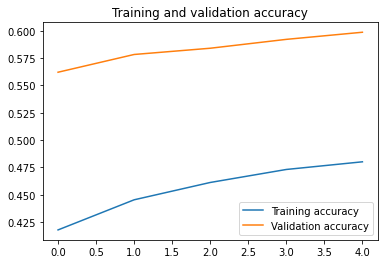

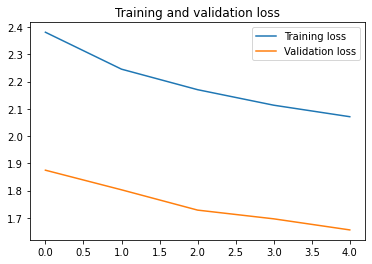

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.plot(epoch_range, acc, label='Training accuracy')
plt.plot(epoch_range, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('model_MobileNet_keras_finetuned.h5')

# **Training our model on tinyimagenet**

In [84]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [85]:
# implement mobile net from scratch
def mobilenet(input_shape, n_classes):
  
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


In [100]:
model = mobilenet((224,224,3),200)

In [97]:
from keras.optimizers import Adam, SGD
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, DepthwiseConv2D, AveragePooling2D, Activation,InputLayer
from keras.layers import BatchNormalization, Dropout
from keras import backend
from keras.preprocessing.image import ImageDataGenerator

In [102]:
model.compile(optimizer = RMSprop(learning_rate = 0.001, rho = 0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [103]:
history = model.fit(train_generator, 
                              validation_data = validation_generator, 
                              epochs=10, 
                              verbose = 1)

Epoch 1/10
391/391 [==============================] - 1001s 3s/step - loss: 4.3531 - accuracy: 0.0938 - val_loss: 6.4786 - val_accuracy: 0.0050
Epoch 2/10
391/391 [==============================] - 994s 3s/step - loss: 3.3463 - accuracy: 0.2366 - val_loss: 6.2515 - val_accuracy: 0.0881
Epoch 3/10
391/391 [==============================] - 996s 3s/step - loss: 2.8482 - accuracy: 0.3318 - val_loss: 3.9835 - val_accuracy: 0.1989
Epoch 4/10
391/391 [==============================] - 996s 3s/step - loss: 2.5075 - accuracy: 0.3979 - val_loss: 3.2264 - val_accuracy: 0.3055
Epoch 5/10
391/391 [==============================] - 996s 3s/step - loss: 2.2556 - accuracy: 0.4479 - val_loss: 3.4325 - val_accuracy: 0.2955
Epoch 6/10
391/391 [==============================] - 993s 3s/step - loss: 2.0436 - accuracy: 0.4933 - val_loss: 3.3160 - val_accuracy: 0.3116
Epoch 7/10
391/391 [==============================] - 993s 3s/step - loss: 1.8699 - accuracy: 0.5296 - val_loss: 2.9272 - val_accuracy: 0.372

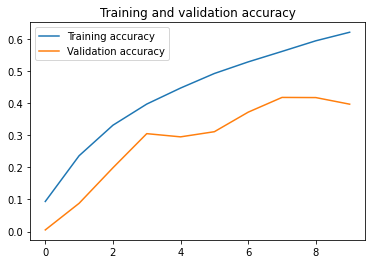

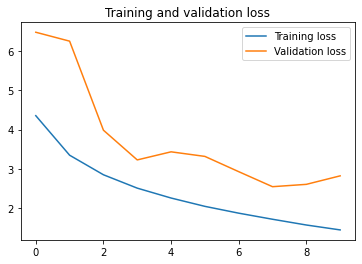

In [104]:
# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.plot(epoch_range, acc, label='Training accuracy')
plt.plot(epoch_range, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()